<a href="https://colab.research.google.com/github/mnmahir/best-fyp/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import Libraries**

In [19]:
# Google Drive
from google.colab import drive
# General
import math
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import itertools
import random as python_random
# Keras Library
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPool2D
from keras.models import Model
from keras import backend as Kbackend
# ScikitLearn
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
# Others

print("Keras version: ", keras.__version__)
print("TensorFlow version:", tf.__version__)

Keras version:  2.4.3
TensorFlow version: 2.3.0


#**Mounting drive**

In [20]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Initialize Functions**

# Tools

In [21]:
############################
# Solving class imbalance
############################
def get_freq_data(generator):
  class_data_labels = generator.classes
  total_class = len(IMAGE_CLASSES)
  freq_out = []

  for i in range(total_class):
    total_label_i = 0
    for ele in class_data_labels:
      if ele == i:
        total_label_i += 1
    freq_out.append(total_label_i)
  
  print("Total number of class is:", total_class, generator.class_indices)
  print("Total image in generator is: ", freq_out)
  return freq_out
############################
# Display training and validation curve
############################
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('Model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['Training', 'Validation'])

############################
# Display confusion matrix
############################
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, subplot = 121):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        cm = np.round(cm,2)
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.subplot(subplot)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))  # Count number of classes for x & y axis lable
    plt.xticks(tick_marks, classes, rotation=45) # x-axis label rotated 45 degree
    plt.yticks(tick_marks, classes) # y-axis label
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
  
############################
# Show generated image
############################
def show_image_generated(generator, index, img_size):
  x, y = generator.__getitem__(index)
  img_plt = math.ceil(math.sqrt(BATCH_SIZE))
  grid_plt = str(img_plt)+str(img_plt)+str(1)
  plt.figure(1, figsize = (img_size,img_size))
  for i in range(BATCH_SIZE):
    plt.subplot(img_plt,img_plt,i+1)
    plt.imshow(x[i])
    plt.title(IMAGE_CLASSES[np.where(y[i] == 1.)[0][0]], fontsize = 2+img_size, pad = 0)
    plt.axis('off')
  plt.show()

############################
# Get input image for pre-trained model
############################
def get_pretrained_model_input_size(MODEL = 'Xception'):
  if MODEL == 'Xception' or MODEL == 'InceptionResNetV2':
    return (299, 299, 3)
  elif MODEL == 'VGG16' or MODEL == 'VGG19' or MODEL == 'NASNetMobile':
    return (224, 224, 3)
  elif MODEL == 'NASNetLarge':
    return (331, 331, 3)
  else:
    print("Invalid model name/ not defined")
    return (0,0,0)


# Data Augmentation

In [22]:
############################
# Training data generator
############################
def get_train_generator():
  print("Getting train generator...")
  image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range = 90,
      vertical_flip = True,
      horizontal_flip = True,
      fill_mode = 'reflect'
  )

  generator = image_generator.flow_from_directory(
      batch_size = BATCH_SIZE,
      directory = train_path,
      shuffle = True,             # Shuffle input after each epoch
      target_size = (IMAGE_WIDTH, IMAGE_HEIGHT),   # Set image size to be [x]px by [y]px set in IMAGE_SIZE
      class_mode = 'categorical',
      seed = SEED,
  )

  return generator
############################
# Validation data generator
############################
def get_valid_generator():
  print("Getting valid generator...")
  image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255
  )

  generator = image_generator.flow_from_directory(
      batch_size = BATCH_SIZE,
      directory = valid_path,
      shuffle = False,             # Shuffle input after each epoch
      target_size = (IMAGE_WIDTH, IMAGE_HEIGHT),   # Set image size to be [x]px by [y]px set in IMAGE_SIZE
      class_mode = 'categorical',
      seed = SEED,
  )

  return generator
############################
# Test data generator
############################
def get_test_generator():
  print("Getting test generator...")
  image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255
  )

  generator = image_generator.flow_from_directory(
      batch_size = BATCH_SIZE,
      directory = valid_path,
      shuffle = False,             # Shuffle input after each epoch
      target_size = (IMAGE_WIDTH, IMAGE_HEIGHT),   # Set image size to be [x]px by [y]px set in IMAGE_SIZE
      class_mode = 'categorical',
      seed = SEED,
  )

  return generator

# Model Development

In [23]:
############################
# Custom model
############################
def get_custom_model(print_summary = False):
  model = Sequential()

  #model.add(Convolution2D(nb_filters, (5, 5), strides=(1, 1), padding='same', input_shape=input_shape))
  model.add(Convolution2D(nb_filters, (5, 5), activation = 'relu', padding='same', input_shape=input_shape))
  #model.add(MaxPooling2D(pool_size=pool_size))

  model.add(Convolution2D(nb_filters, (5, 5), activation = 'relu', padding='same'))
  model.add(MaxPool2D(pool_size=pool_size))
  model.add(Dropout(rate=0.25))
  #model.add(Convolution2D(nb_filters, (3, 3)))
  #model.add(Activation('relu'))

  #model.add(Activation('tanh'))
  model.add(Convolution2D(nb_filters*2, (3, 3), activation='relu', padding='same'))

  model.add(Convolution2D(nb_filters*2, (3, 3), activation='relu', padding='same'))

  model.add(Convolution2D(nb_filters*2, (3, 3), activation='relu', padding='same'))
  model.add(MaxPool2D(pool_size=pool_size))
  model.add(Dropout(rate=0.25))

  model.add(Convolution2D(nb_filters*2, (3, 3), activation='relu', padding='same'))

  model.add(Convolution2D(nb_filters*2, (3, 3), activation='relu', padding='same'))
  model.add(MaxPool2D(pool_size=pool_size))
  model.add(Dropout(rate=0.25))

  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(rate=0.5))

  #model.add(Dense(128, activation='relu'))
  #model.add(Dropout(0.5))
  #model.add(Dropout(0.15))

  model.add(Dense(4, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  if print_summary:
    model.summary()

  return model

In [24]:
############################
# Transfer learning model
############################
def get_pretrained_model(transfer_learning_model = 'None', weights = None, unfreeze_last_layer = 0, print_summary = False):
  ################ Choose Pre-trained model #########################
  if transfer_learning_model == 'Xception':
    selected_model = "Xception pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.Xception(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)
  
  elif transfer_learning_model == 'VGG16':
    selected_model = "VGG16 pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.VGG16(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)
  
  elif transfer_learning_model == 'VGG19':
    selected_model = "VGG19 pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.VGG19(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)
  
  elif transfer_learning_model == 'InceptionResNetV2':
    selected_model = "InceptionResNetV2 pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.InceptionResNetV2(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)
  
  elif transfer_learning_model == 'NASNetLarge':
    selected_model = "NASNetLarge pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.NASNetLarge(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)
  
  elif transfer_learning_model == 'EfficientNetB7':
    selected_model = "EfficientNetB7 pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.EfficientNetB7(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)
  
  elif transfer_learning_model == 'DenseNet201':
    selected_model = "DenseNet201 pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.DenseNet201(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)
  
  else:
    print("Not defined / Does not exist")
    return 0
  ##################################################################
  # Freeze early layers
  for layer in pretrained_model.layers:
    if unfreeze_last_layer < len(pretrained_model.layers):
      layer.trainable = False
      unfreeze_last_layer += 1

  # Print summary of pre-trained model
  if print_summary:
    pretrained_model.summary()
    if unfreeze_last_layer > 0:
      print("####################### UNFREEZED LAYER #########################")
      print("Layer            Trainable")
      for layer in pretrained_model.layers:
        if layer.trainable == True:
          sp = '      '[len(layer.name)-9:]
          print(layer.name, sp, layer.trainable)

  model = Sequential()
  model.add(pretrained_model)

  # Fine tuning our layers - you can add more if you want
  model.add(Flatten())
  model.add(Dropout(0.8))
  model.add(Dense(1024, activation = 'relu'))

  # Prediction layer
  model.add(layers.Dense(len(IMAGE_CLASSES), activation = 'softmax'))

  # Compile model
  model.compile(
      optimizer='adam',
      loss = 'categorical_crossentropy',
      metrics=['accuracy']
  )

  if print_summary:
    print("###################### AFTER FINE TUNING ########################")
    model.summary()
    print(selected_model)

  return model


# **Training**

In [25]:
# Path where dataset is located
dataset_path = '/content/drive/My Drive/FYP Stuff/Datasets/#old/Dataset 1C'
train_path = dataset_path + '/Train'
valid_path = dataset_path + '/Test'    # Some literature use the term "test set" / "valid set" but it is actually a "dev set". This is the set that is iterated during training.
test_path = dataset_path + '/Test'  # Test set helps evaluate how good your final system is. It's ok not to have test set.

In [26]:
IMAGE_CLASSES = ['Grade I','Grade II','Grade III', 'Normal']         # Naming Classes (The names must be in the same order as in dataset folder (usually alphabetically))
MODEL = 'Xception'
BATCH_SIZE = 64                 # Mini-batch size
SEED = 2020                     # Fixed randomness (For reproducible result!)
python_random.seed(SEED)        # necessary for starting core Python generated random numbers in a well-defined state.
np.random.seed(SEED)            # necessary for starting Numpy generated random numbers in a well-defined state.
tf.random.set_seed(SEED)        # will make random number generation in the TensorFlow backend have a well-defined initial state.

IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL = get_pretrained_model_input_size(MODEL)
print("Training on", MODEL)
print("Input:",IMAGE_WIDTH,'x',IMAGE_HEIGHT,'x',IMAGE_CHANNEL)

Training on Xception
Input: 299 x 299 x 3


In [27]:
train_generator = get_train_generator()
valid_generator = get_valid_generator()
test_generator = get_test_generator()

Getting train generator...
Found 2708 images belonging to 4 classes.
Getting valid generator...
Found 676 images belonging to 4 classes.
Getting test generator...
Found 676 images belonging to 4 classes.


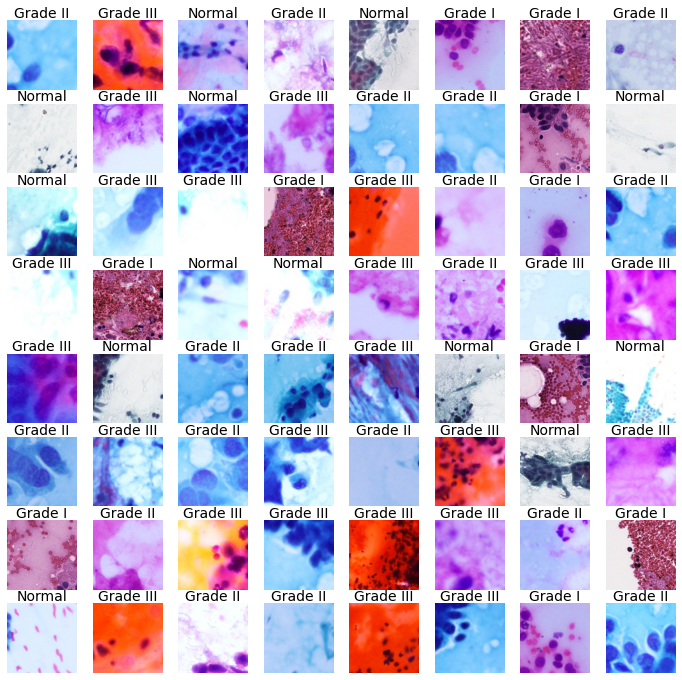

In [28]:
# Show image generated by generator
show_image_generated(train_generator, index = 3, img_size = 12)  # Print image generated by generator. Change index to see different batch (start at 0)

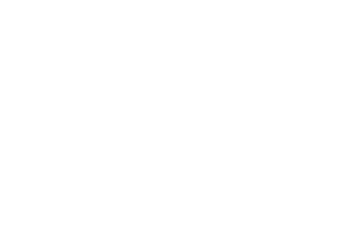

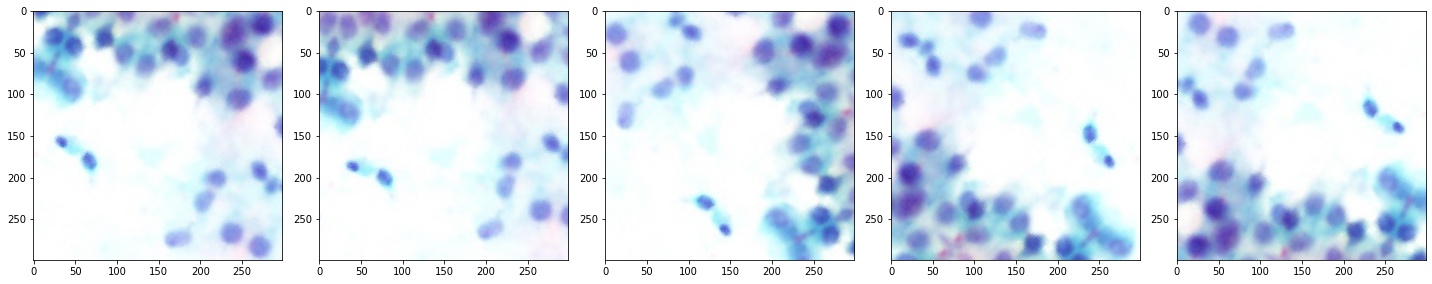

In [35]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    plt.axis('off')
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    
    plt.show()

augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [30]:
# Check number of image in each class
train_freq = get_freq_data(train_generator)
valid_freq = get_freq_data(valid_generator)
valid_data_freq = np.array(valid_freq)/np.array(train_freq)
print("Valid data Percentage:",valid_data_freq)



Total number of class is: 4 {'Grade I': 0, 'Grade II': 1, 'Grade III': 2, 'Normal': 3}
Total image in generator is:  [581, 1035, 648, 444]
Total number of class is: 4 {'Grade I': 0, 'Grade II': 1, 'Grade III': 2, 'Normal': 3}
Total image in generator is:  [145, 258, 162, 111]
Valid data Percentage: [0.24956971 0.24927536 0.25       0.25      ]


In [31]:
model = get_pretrained_model(MODEL, weights = 'imagenet', unfreeze_last_layer = 0, print_summary = True,)

Xception pre-trained model selected
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________

In [32]:
EPOCH = 50                      # Number of training epoch

history = model.fit(
    x = train_generator,
    validation_data = valid_generator,
    epochs = EPOCH,
    verbose = 1,
    steps_per_epoch = train_generator.samples / train_generator.batch_size ,
    validation_steps = valid_generator.samples / valid_generator.batch_size
)
# Loss and Accuracy
plt.subplots(figsize=(10,5))
plt.tight_layout()
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 121)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', 122)

Epoch 1/50
43/42 [==============================] - 61s 1s/step - loss: 4.0121 - accuracy: 0.6041 - val_loss: 0.6617 - val_accuracy: 0.7633
Epoch 2/50
43/42 [==============================] - 61s 1s/step - loss: 0.6283 - accuracy: 0.7629 - val_loss: 0.5654 - val_accuracy: 0.7781
Epoch 3/50
18/42 [===========>..................] - ETA: 30s - loss: 0.5589 - accuracy: 0.7852

KeyboardInterrupt: ignored

# **Save & Reload Model**

In [ ]:
SAVE_MODEL_NAME = 'awesome_model.h5'         # Name of the model
model.save(SAVE_MODEL_NAME) #Save
reloaded_model = tf.keras.models.load_model(SAVE_MODEL_NAME) #Load

# **Evaluation**

**Loss and Accuracy**

In [ ]:
plt.subplots(figsize=(10,5))
plt.tight_layout()
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 121)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', 122)

**Confusion Matrix**

In [ ]:
# True label
true_labels = test_generator.classes  # Get label of valid_generator
# Prediction label
predictions = reloaded_model.predict(x=test_generator, steps=len(test_generator),verbose = 0)
pred_labels = np.argmax(predictions, axis=-1)

In [ ]:
# Plot Confusion Matrix
cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels)
plt.subplots(figsize=(12,5))
plot_confusion_matrix(cm=cm, classes=IMAGE_CLASSES, title='Confusion Matrix',normalize=False, subplot=121)
plot_confusion_matrix(cm=cm, classes=IMAGE_CLASSES, title='Normalized Confusion Matrix',normalize=True, subplot=122)

**Other Metrics**

In [ ]:
report = metrics.classification_report(y_true = true_labels, y_pred = pred_labels, target_names=IMAGE_CLASSES)
print(report)